# Data Collection

The main goal of this capstone project is to produce a workable chatbot with the ability to "speak" with its users. The dataset used for this Jupyter notebook is collected from the following website: https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html.

The dataset is published in 2011 by Cristian Danescu-Niculescu-Mizil and Lillian Lee of Cornell University for the Proceedings of the Workshop on Cognitive Modeling and Computational Linguistics at the Association of Computational Linguistics (ACL).

<b>Citation:</b> Cristian Danescu-Niculescu-Mizil and Lillian Lee. 2011. Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs. <i>In Proceedings of the Workshop on Cognitive Modeling and Computational Linguistics, ACL 2011</i>, pp.76-87.

This data can be obtained publically in the form of a compressed zip file from their website. For this capstone project, two of the extracted files will be used for our data wrangling: "movie_lines.txt" and "movie_conversations.txt".

"movie_lines.txt" is a file containing a collection of fictional conversations extracted from raw movie scripts, which includes:

- 220,579 conversational exchanges between 10,292 pairs of movie characters
- involves 9,035 characters from 617 movies
- in total 304,713 utterances

"movie_conversations.txt" is a file containing a collection of lists that captures the order of utterances used in those conversational exchanges.

# Data Cleaning

To begin our data wrangling process, the following dependencies are loaded onto our Jupyter notebook:

In [1]:
# Import Dependencies
import pandas as pd
import string
import matplotlib.pyplot as plt
import re
import os
from itertools import tee, chain

In [2]:
# Creating pathway to dataset
work_dir = os.getcwd()
main_chatbot_dir = os.path.dirname(work_dir)
dataset_dir = main_chatbot_dir + '/datasets'
cornell_dataset = dataset_dir + '/cornell_movie_dialogs_corpus'

In [3]:
# Grabbing data files of interest
movie_lines_file = cornell_dataset + '/movie_lines.txt'
movie_conversations_file = cornell_dataset + '/movie_conversations.txt'

In the text file "movie_lines.txt" the authors structured the data into "fields" and is separated by a field separator, " +++$+++ ". In the file, there are 5 fields:

- lineID
- characterID (who uttered this phrase)
- movieID
- character name
- text of the utterance

Since our data was structured similar to that of a csv file, I unpacked the data using Pandas' read_csv() function. Unfortunately, since the default engine used in read_csv(), engine='c' does not support regex separators, the parameter engine='python' was used to avoid a warning message. In order to use " +++$+++ " as our separator, the non-alphanumeric characters must also be separated by "\\" when inputed, else an error would appear.

In [4]:
# Loading movie_lines.txt as a Pandas DataFrame
movie_lines_fields = ["Line_ID", "Character_ID", "Movie_ID", "Character_Name", "Movie_Line"]
movie_lines = pd.read_csv(movie_lines_file, sep=" \+\+\+\$\+\+\+ ", 
                          engine='python', names=movie_lines_fields)

In [5]:
movie_lines

,Line_ID,Character_ID,Movie_ID,Character_Name,Movie_Line
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.
...,...,...,...,...,...
304708,L666371,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...
304709,L666370,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...
304710,L666369,u9030,m616,DURNFORD,"Your orders, Mr Vereker?"
304711,L666257,u9030,m616,DURNFORD,"Good ones, yes, Mr Vereker. Gentlemen who can ..."


In [6]:
# Just in case, we'll removing an extraneous spaces from Movie_Line with .split()
# and .capitalize() on Character_Name
movie_lines['Character_Name'] = movie_lines['Character_Name'].apply(lambda x: str(x).capitalize())
movie_lines['Movie_Line'] = movie_lines['Movie_Line'].apply(lambda x: ' '.join(str(x).split()))

In [7]:
# We'll call one line to see if the formatting end up what we wanted before further processing
movie_lines.loc[movie_lines['Line_ID'] == 'L194']

,Line_ID,Character_ID,Movie_ID,Character_Name,Movie_Line
68,L194,u0,m0,Bianca,Can we make this quick? Roxanne Korrine and An...


In [8]:
movie_lines.loc[movie_lines['Line_ID'] == 'L194'].values

array([['L194', 'u0', 'm0', 'Bianca',
        'Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.']],
      dtype=object)

In [9]:
# Moving forward, we'll use Line_ID as our DataFrame index
movie_lines = movie_lines.set_index('Line_ID')

In [10]:
movie_lines

,Character_ID,Movie_ID,Character_Name,Movie_Line
Line_ID,,,,
L1045,u0,m0,Bianca,They do not!
L1044,u2,m0,Cameron,They do to!
L985,u0,m0,Bianca,I hope so.
L984,u2,m0,Cameron,She okay?
L925,u0,m0,Bianca,Let's go.
...,...,...,...,...
L666371,u9030,m616,Durnford,Lord Chelmsford seems to want me to stay back ...
L666370,u9034,m616,Vereker,I'm to take the Sikali with the main column to...
L666369,u9030,m616,Durnford,"Your orders, Mr Vereker?"


In [11]:
movie_lines.loc['L194', 'Movie_Line']

'Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.'

There appears to be dashes in our dataset.

In [12]:
# Checking for lines containing dashes
movie_lines.loc[movie_lines['Movie_Line'].str.contains('-') == True, 'Movie_Line']

Line_ID
L872          Okay -- you're gonna need to learn how to lie.
L405       Lesbian? No. I found a picture of Jared Leto i...
L277               Well, there's someone I think might be --
L202       The thing is, Cameron -- I'm at the mercy of a...
L200       No, no, it's my fault -- we didn't have a prop...
                                 ...                        
L666363    From the Cook, Sir They saw me dip your shavin...
L666389    Excuse me, My Lord. Norris-Newman, of "The Sta...
L666482    Intelligence? Sources of your own? Did it not ...
L666384    Er, called Noggs, Sir Actual name is Norris-Ne...
L666576    Keep steady. You're the best shots of the Twen...
Name: Movie_Line, Length: 33702, dtype: object

In [13]:
# Cleaning data such that double dashes are replaced with single dashes and words with dashes gets fixed
movie_lines['Movie_Line'] = movie_lines['Movie_Line'].apply(lambda x: x.replace('- ', '-'))
movie_lines['Movie_Line'] = movie_lines['Movie_Line'].apply(lambda x: x.replace('--', '- '))

In [14]:
movie_lines.loc['L194', 'Movie_Line']

'Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break-up on the quad. Again.'

In [15]:
movie_lines.loc['L872', 'Movie_Line']

"Okay - you're gonna need to learn how to lie."

In [16]:
movie_lines.loc['L666384', 'Movie_Line']

'Er, called Noggs, Sir Actual name is Norris-Newman. He presented credentials from "The Standard".'

Before I get the dialogues into chronological order, I first need the list contained in "movie_conversations.txt".

In the text file "movie_conversations.txt" the authors similarly structured the data into "fields" and is separated by a field separator, " +++$+++ ". In this file, there are 5 fields:

- characterID of the first character involved in the conversation
- characterID of the second character involved in the conversation
- movieID of the movie in which the conversation occurred
- list of the utterances that make the conversation, in chronological order

In [17]:
# Loading movie_conversations.txt using definitions from README.txt
movie_conversations_fields = ["Character_ID_1", "Character_ID_2", "Movie_ID", "Movie_Line_Order"]
movie_conversations = pd.read_csv(movie_conversations_file, sep=" \+\+\+\$\+\+\+ ", 
                                  engine='python', names=movie_conversations_fields)

In [18]:
movie_conversations

,Character_ID_1,Character_ID_2,Movie_ID,Movie_Line_Order
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"
...,...,...,...,...
83092,u9028,u9031,m616,"['L666324', 'L666325', 'L666326', 'L666327']"
83093,u9028,u9031,m616,"['L666575', 'L666576']"
83094,u9030,u9034,m616,"['L666256', 'L666257']"
83095,u9030,u9034,m616,"['L666369', 'L666370', 'L666371', 'L666372']"


In [19]:
movie_conversations['Movie_Line_Order'][0]

"['L194', 'L195', 'L196', 'L197']"

In [20]:
# The list of strings appears to be enclosed in double quotations ""
# We'll just convert it into an ordinary list of strings without quotations
movie_conversations['Movie_Line_Order'] = movie_conversations['Movie_Line_Order'].apply(lambda x: eval(' '.join(x.split())))

In [21]:
movie_conversations

,Character_ID_1,Character_ID_2,Movie_ID,Movie_Line_Order
0,u0,u2,m0,"[L194, L195, L196, L197]"
1,u0,u2,m0,"[L198, L199]"
2,u0,u2,m0,"[L200, L201, L202, L203]"
3,u0,u2,m0,"[L204, L205, L206]"
4,u0,u2,m0,"[L207, L208]"
...,...,...,...,...
83092,u9028,u9031,m616,"[L666324, L666325, L666326, L666327]"
83093,u9028,u9031,m616,"[L666575, L666576]"
83094,u9030,u9034,m616,"[L666256, L666257]"
83095,u9030,u9034,m616,"[L666369, L666370, L666371, L666372]"


In [22]:
movie_conversations['Movie_Line_Order'][0]

['L194', 'L195', 'L196', 'L197']

Now that we have our list containing conversational exchanges in chronological order, I'll replace the Line_ID with the actual movie line.

The following function, grab_lines(), will do this for us.

In [23]:
# Defining function to convert Movie_Line_Order into actual text
def grab_lines(movie_line_list):
    """Function takes list from labels from movie_conversations['Movie_Line_Order'] and turns it into list dialogue"""
    return [movie_lines.loc[line, 'Movie_Line'] for line in movie_line_list]

For the chatbot, I plan on using dialogue pairs in the form of a comment and a reply (comment, reply) to train it. So I created an additional function, make_pairs(), to perform this.

In [24]:
# Defining functions to convert conversations into (comment, reply) pairs
def make_pairs(movie_line_list):
    """Turn list into [list[0], list[1]], [list[1], list[2]], [list[2], list[3]], ..."""
    a, b = tee(movie_line_list)
    next(b, None)
    return [[i,j] for i, j in zip(a, b)]

In [25]:
# Generate (comment, reply) pairs into from Movie_Line_Order using make_pairs()
movie_conversations['Dialogue_Pairs'] = movie_conversations['Movie_Line_Order'].apply(lambda x: make_pairs(x))

In [26]:
movie_conversations

,Character_ID_1,Character_ID_2,Movie_ID,Movie_Line_Order,Dialogue_Pairs
0,u0,u2,m0,"[L194, L195, L196, L197]","[[L194, L195], [L195, L196], [L196, L197]]"
1,u0,u2,m0,"[L198, L199]","[[L198, L199]]"
2,u0,u2,m0,"[L200, L201, L202, L203]","[[L200, L201], [L201, L202], [L202, L203]]"
3,u0,u2,m0,"[L204, L205, L206]","[[L204, L205], [L205, L206]]"
4,u0,u2,m0,"[L207, L208]","[[L207, L208]]"
...,...,...,...,...,...
83092,u9028,u9031,m616,"[L666324, L666325, L666326, L666327]","[[L666324, L666325], [L666325, L666326], [L666..."
83093,u9028,u9031,m616,"[L666575, L666576]","[[L666575, L666576]]"
83094,u9030,u9034,m616,"[L666256, L666257]","[[L666256, L666257]]"
83095,u9030,u9034,m616,"[L666369, L666370, L666371, L666372]","[[L666369, L666370], [L666370, L666371], [L666..."


In [27]:
# We'll make a simple list comprehension to test our grab_lines() function
[grab_lines(line) for line in movie_conversations['Dialogue_Pairs'][0]]

[['Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break-up on the quad. Again.',
  "Well, I thought we'd start with pronunciation, if that's okay with you."],
 ["Well, I thought we'd start with pronunciation, if that's okay with you.",
  'Not the hacking and gagging and spitting part. Please.'],
 ['Not the hacking and gagging and spitting part. Please.',
  "Okay... then how 'bout we try out some French cuisine. Saturday? Night?"]]

In [28]:
# Convert our list of dialogue pair labels into actual dialogue
movie_conversations['Dialogue_Pairs_Text'] = movie_conversations['Dialogue_Pairs'].apply(lambda x: [grab_lines(line) for line in x])

In [29]:
movie_conversations

,Character_ID_1,Character_ID_2,Movie_ID,Movie_Line_Order,Dialogue_Pairs,Dialogue_Pairs_Text
0,u0,u2,m0,"[L194, L195, L196, L197]","[[L194, L195], [L195, L196], [L196, L197]]",[[Can we make this quick? Roxanne Korrine and ...
1,u0,u2,m0,"[L198, L199]","[[L198, L199]]",[[You're asking me out. That's so cute. What's...
2,u0,u2,m0,"[L200, L201, L202, L203]","[[L200, L201], [L201, L202], [L202, L203]]","[[No, no, it's my fault - we didn't have a pro..."
3,u0,u2,m0,"[L204, L205, L206]","[[L204, L205], [L205, L206]]","[[Why?, Unsolved mystery. She used to be reall..."
4,u0,u2,m0,"[L207, L208]","[[L207, L208]]","[[Gosh, if only we could find Kat a boyfriend...."
...,...,...,...,...,...,...
83092,u9028,u9031,m616,"[L666324, L666325, L666326, L666327]","[[L666324, L666325], [L666325, L666326], [L666...",[[Do you think she might be interested in some...
83093,u9028,u9031,m616,"[L666575, L666576]","[[L666575, L666576]]",[[Choose your targets men. That's right Watch ...
83094,u9030,u9034,m616,"[L666256, L666257]","[[L666256, L666257]]",[[Colonel Durnford... William Vereker. I hear ...
83095,u9030,u9034,m616,"[L666369, L666370, L666371, L666372]","[[L666369, L666370], [L666370, L666371], [L666...","[[Your orders, Mr Vereker?, I'm to take the Si..."


In [30]:
movie_conversations['Dialogue_Pairs_Text'][0]

[['Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break-up on the quad. Again.',
  "Well, I thought we'd start with pronunciation, if that's okay with you."],
 ["Well, I thought we'd start with pronunciation, if that's okay with you.",
  'Not the hacking and gagging and spitting part. Please.'],
 ['Not the hacking and gagging and spitting part. Please.',
  "Okay... then how 'bout we try out some French cuisine. Saturday? Night?"]]

Now that we have our lists of dialogue pair labels as lists of dialogue pair text, I use this new column to generate a new DataFrame. Before that, we convert the list of lists into individual lists.

In [31]:
# Using movie_conversations dataframe to generate individual (comment, reply) pairs
individual_dialogue_pairs = []
for pair_num in movie_conversations['Dialogue_Pairs_Text']:
    for pair in pair_num:
        individual_dialogue_pairs.append(pair)

In [32]:
individual_dialogue_pairs[0]

['Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break-up on the quad. Again.',
 "Well, I thought we'd start with pronunciation, if that's okay with you."]

In [33]:
# Defining new dataframe specifically for these Comment and Reply pairs
columns = ['Comment', 'Reply']
df = pd.DataFrame(individual_dialogue_pairs, columns=columns)

In [34]:
df

,Comment,Reply
0,Can we make this quick? Roxanne Korrine and An...,"Well, I thought we'd start with pronunciation,..."
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
3,You're asking me out. That's so cute. What's y...,Forget it.
4,"No, no, it's my fault - we didn't have a prope...",Cameron.
...,...,...
221611,"Your orders, Mr Vereker?",I'm to take the Sikali with the main column to...
221612,I'm to take the Sikali with the main column to...,Lord Chelmsford seems to want me to stay back ...
221613,Lord Chelmsford seems to want me to stay back ...,I think Chelmsford wants a good man on the bor...
221614,"Well I assure you, Sir, I have no desire to cr...","And I assure you, you do not In fact I'd be ob..."


While we have our text now, there could be text modifiers, strings like "\<b\>" or "\<\/b\>" since they might be pulled from an online source. I would like to check to see if there are any in our dataset and replace them with white spaces.

In [35]:
# Checking number of cases with the character '<'
num_of_lines = []
for i, comment in enumerate(df['Comment']):
    if '<' in comment:
        num_of_lines.append(comment)
len(num_of_lines) # There's quite a bit of them, it would appear

1883

We'll create a few functions to clean up these cases.

In [36]:
# Defining function to replace text modifiers with white spaces
def replace_modifiers(text):
    text = text.replace('<b>',' ').replace('</b>',' ').replace('<B>',' ').replace('</B>',' ')
    text = text.replace('<i>',' ').replace('</i>',' ').replace('<I>',' ').replace('</I>',' ')
    text = text.replace('<u>',' ').replace('</u>',' ').replace('<U>',' ').replace('</U>',' ')
    text = text.replace('<pre>',' ').replace('</pre>',' ').replace('<PRE>',' ').replace('</PRE>',' ')
    text = text.replace('<html>',' ').replace('</html>',' ').replace('<HTML>',' ').replace('</HTML>',' ')
    return text

# Defining function to replace any special cases that are found with white spaces or text
def remove_special_cases(text):
    text = text.replace('<u<',' ')
    text = text.replace('mrcroscope','microscope')
    text = text.replace('L-A-U-G-H','laugh')
    text = text.replace('G-d.','God.')
    text = text.replace('nev-er','never')
    return text

In [37]:
df['Comment'] = df['Comment'].apply(replace_modifiers)
df['Comment'] = df['Comment'].apply(remove_special_cases)
df['Reply'] = df['Reply'].apply(replace_modifiers)
df['Reply'] = df['Reply'].apply(remove_special_cases)

In [38]:
num_of_lines = []
for i, comment in enumerate(df['Comment']):
    if '<' in comment:
        num_of_lines.append(comment)
num_of_lines

["<Cardiac Red Alert> we're stopping the Heart.",
 "I don't mean to be inquisitive. But this <CMDF> - for all I know it could stand for <Consolidated Mobilization of Female Delinquents>?",
 '<Combined Miniature Deterrent Forces>.',
 "We can shrink an Army - with all its equipment - and put it in a bottle cap. That's why we call it <Combined Miniature Deterrent Forces>.",
 "You mean <I'm> going along?",
 "Wait a minute! They can't shrink <me>!",
 "I'll be standing by. <I'll> know.",
 'Never saw <that>. Not even under an electron-microscope.',
 "I'll do nothing of the sort! The operation is <my> responsibility! I won't do it, and that's final!",
 "The Medieval Philosophers were right... <Man> is the center of the Universe... We stand in the middle of Infinity, between Outer and Inner Space. And there's no limit to either.",
 'Cough? If he can kick up a storm by just <breathing> - ',
 "We feel great, don't we? Just <great>?!",
 '<<belch>>']

In [39]:
num_of_lines = []
for i, comment in enumerate(df['Comment']):
    if '>' in comment:
        num_of_lines.append(comment)
num_of_lines

["<Cardiac Red Alert> we're stopping the Heart.",
 "I don't mean to be inquisitive. But this <CMDF> - for all I know it could stand for <Consolidated Mobilization of Female Delinquents>?",
 '<Combined Miniature Deterrent Forces>.',
 "We can shrink an Army - with all its equipment - and put it in a bottle cap. That's why we call it <Combined Miniature Deterrent Forces>.",
 "You mean <I'm> going along?",
 "Wait a minute! They can't shrink <me>!",
 "I'll be standing by. <I'll> know.",
 'Never saw <that>. Not even under an electron-microscope.',
 "I'll do nothing of the sort! The operation is <my> responsibility! I won't do it, and that's final!",
 "The Medieval Philosophers were right... <Man> is the center of the Universe... We stand in the middle of Infinity, between Outer and Inner Space. And there's no limit to either.",
 'Cough? If he can kick up a storm by just <breathing> - ',
 "We feel great, don't we? Just <great>?!",
 '<<belch>>',
 'I gotta know... did it work>',
 '"Wilt thou be

In [40]:
num_of_lines = []
for i, comment in enumerate(df['Reply']):
    if '<' in comment:
        num_of_lines.append(comment)
num_of_lines

["< Maybe it's something in the water.",
 '<Me>?',
 '<Combined Miniature Deterrent Forces>.',
 "We can shrink an Army - with all its equipment - and put it in a bottle cap. That's why we call it <Combined Miniature Deterrent Forces>.",
 "You mean <I'm> going along?",
 "Wait a minute! They can't shrink <me>!",
 "And no matter what happens, you're to take orders <only> from Dr. Michaels, understand?",
 "I'll do nothing of the sort! The operation is <my> responsibility! I won't do it, and that's final!",
 'It I can clear this Central Nerve, that <may> be enough...',
 'Cough? If he can kick up a storm by just <breathing> - ',
 "Nothing has changed as far as <my> authority goes! He is <not> going to operate! Not in the little time we have left! There's no chance of success! It's sheer suicide for all of us!",
 "We feel great, don't we? Just <great>?!",
 '<<belch>>']

In [41]:
num_of_lines = []
for i, comment in enumerate(df['Reply']):
    if '>' in comment:
        num_of_lines.append(comment)
num_of_lines

['<Me>?',
 '<Combined Miniature Deterrent Forces>.',
 "We can shrink an Army - with all its equipment - and put it in a bottle cap. That's why we call it <Combined Miniature Deterrent Forces>.",
 "You mean <I'm> going along?",
 "Wait a minute! They can't shrink <me>!",
 "And no matter what happens, you're to take orders <only> from Dr. Michaels, understand?",
 "I'll do nothing of the sort! The operation is <my> responsibility! I won't do it, and that's final!",
 'It I can clear this Central Nerve, that <may> be enough...',
 'Cough? If he can kick up a storm by just <breathing> - ',
 "Nothing has changed as far as <my> authority goes! He is <not> going to operate! Not in the little time we have left! There's no chance of success! It's sheer suicide for all of us!",
 "We feel great, don't we? Just <great>?!",
 '<<belch>>',
 '"Wilt thou be gone? It is not yet near day> It was the nightingale and not the lark That pierced the fearful hollow of thine ear. Nightly she sings on yon pomegranat

The problem seems to be mostly resolved. The rest of these cases could be fixed when we remove punctuations later on.

In text, abbreviations and acronyms are typically used to shorten lengthy names such as the United States (U.S.) or the National Basketball Association (NBA). In our case, we could try and remove dots from abbreviations and acronyms to simplify our text.

In [42]:
# Defining function to remove dots from text
def remove_dots(text):
    return text.replace('.','')

In [43]:
# Applying remove_dots() to DataFrames
df["Comment"] = df['Comment'].apply(remove_dots)
df['Reply'] = df['Reply'].apply(remove_dots)

Now that we have our dialogue pairs, we'll clean the data up a bit more by first expanding any word contraction. To do this, I create a function called expand_contractions() to do this.

In [44]:
# Defining function to expand contractions
def expand_contractions(text):
    expanded = [''.join(contractions_dict.get(i,i)) for i in text.lower().split()]
    return ' '.join(expanded)

In [45]:
# Dictionary of English Contractions
contractions_dict = {"i'm":"i am","i'd":"i would","i'll":"i will","i've":"i have","isn't":"is not",
                     "you're":"you are","you've":"you have","you'll":"you will",
                     "you'd":"you would","he's":"he is","he'll":"he will",
                     "he'd":"he would","she's":"she is","she'll":"she will",
                     "she'd":"she would","it's":"it is","it'll":"it will",
                     "it'd":"it would","we're":"we are","we'd":"we would",
                     "we'll":"we will","we've":"we have","they're":"they are",
                     "they'd":"they had","they've":"they have","they'll":"they will",
                     "somebody'll":"somebody will","who's":"who is","who're":"who are",
                     "who've":"who have","who'd":"who would","who'll":"who will",
                     "what's":"what is","what're":"what are","what've":"what have","what'd":"what had",
                     "what'll":"what will","when's":"when is","when'll":"when will",
                     "why's":"why is","why'd":"why would","why'll":"why will",
                     "why're":"why are","how's":"how is","how're":"how are",
                     "how've":"how have","how'll":"how will","how'd":"how would",
                     "which's":"which is","which'd":"which would","which'll":"which will",
                     "this'll":"this will","these're":"these are","these'll":"these will",
                     "that's":"that is","that'd":"that would","that'll":"that will",
                     "those're":"those are","those'd":"those would","those'll":"those will",
                     "here's":"here is","here're":"here are","here'd":"here would",
                     "here'll":"here will","there's":"there is","there're":"there are",
                     "there'd":"there would","there'll":"there will","ain't":"is not",
                     "aren't":"are not","wasn't":"was not","weren't":"were not",
                     "won't":"will not","will've":"will have","can't":"cannot",
                     "couldn't":"could not","could've":"could have","shouldn't":"should have",
                     "should've":"should have","wouldn't":"would not","would've":"would have",
                     "might've":"might have","mustn't":"must not","must've":"must have",
                     "don't":"do not","doesn't":"does not","didn't":"did not",
                     "haven't":"have not","hadn't":"had not","gimme":"give me",
                     "imma":"I am about to","gonna":"going to","wanna":"want to",
                     "hafta":"have to","woulda":"would have","coulda":"could have",
                     "shoulda":"should have","ma'am":"madam","howdy":"how do you do",
                     "let's":"let us","y'all":"you all","a'ight":"alright","'bout":"about",
                     "cap'n":"captain","'cause":"because","'cept":"except","dammit":"damn it",
                     "'em":"them","g'day":"good day","gotta":"got to","helluva":"hell of a",
                     "i'd've":"i would have","innit":"is it not","iunno":"i do not know",
                     "kinda":"kind of","methinks":"i think","'neath":"beneath",
                     "needn't":"need not","'round":"around","oughtn't":"ought not",
                     "ol'":"old","shan't":"shall not","'til":"until","'tis":"it is",
                     "'twas":"it was","'tween":"between","'twere":"it were",
                     "whatcha":"what are you","y'all'd've":"you all would have",
                     "y'all'd'n't've":"you all would not have","y'all're":"you all are",
                     "y'at":"you at","yes'm":"yes madam","yessir":"yes sir","ain't":"is not"}

In [46]:
# Expanding contractions in our data using expand_contractions
df["Expanded Comment"] = df['Comment'].apply(expand_contractions)
df['Expanded Reply'] = df['Reply'].apply(expand_contractions)

In [47]:
df

,Comment,Reply,Expanded Comment,Expanded Reply
0,Can we make this quick? Roxanne Korrine and An...,"Well, I thought we'd start with pronunciation,...",can we make this quick? roxanne korrine and an...,"well, i thought we would start with pronunciat..."
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part ...,"well, i thought we would start with pronunciat...",not the hacking and gagging and spitting part ...
2,Not the hacking and gagging and spitting part ...,Okay then how 'bout we try out some French cui...,not the hacking and gagging and spitting part ...,okay then how about we try out some french cui...
3,You're asking me out That's so cute What's you...,Forget it,you are asking me out that is so cute what is ...,forget it
4,"No, no, it's my fault - we didn't have a prope...",Cameron,"no, no, it is my fault - we did not have a pro...",cameron
...,...,...,...,...
221611,"Your orders, Mr Vereker?",I'm to take the Sikali with the main column to...,"your orders, mr vereker?",i am to take the sikali with the main column t...
221612,I'm to take the Sikali with the main column to...,Lord Chelmsford seems to want me to stay back ...,i am to take the sikali with the main column t...,lord chelmsford seems to want me to stay back ...
221613,Lord Chelmsford seems to want me to stay back ...,I think Chelmsford wants a good man on the bor...,lord chelmsford seems to want me to stay back ...,i think chelmsford wants a good man on the bor...
221614,"Well I assure you, Sir, I have no desire to cr...","And I assure you, you do not In fact I'd be ob...","well i assure you, sir, i have no desire to cr...","and i assure you, you do not in fact i would b..."


Now that we have our data properly organized in the format that we wanted, let's explore our data a bit before exporting it. 

In [48]:
# Exploring the data a bit
df['Comment Length'] = df['Expanded Comment'].str.split().apply(lambda x: len(x))
df['Reply Length'] = df['Expanded Reply'].str.split().apply(lambda x: len(x))

In [49]:
df["Comment Length"].describe()

count    221616.000000
mean         10.798318
std          11.910792
min           0.000000
25%           4.000000
50%           7.000000
75%          13.000000
max         319.000000
Name: Comment Length, dtype: float64

In [50]:
df["Reply Length"].describe()

count    221616.00000
mean         11.18361
std          12.73379
min           0.00000
25%           4.00000
50%           7.00000
75%          14.00000
max         556.00000
Name: Reply Length, dtype: float64

There appears to be dialogue lines with hundreds of words.

In [51]:
df[df["Comment Length"] > 300]

,Comment,Reply,Expanded Comment,Expanded Reply,Comment Length,Reply Length
35134,"Yeah Yeah It bothers me a lot 'Cause, you see,...","You're not a loser, Eddie You're a winner Some...","yeah yeah it bothers me a lot 'cause, you see,...","you are not a loser, eddie you are a winner so...",306,24
135505,"When you dropped me off at the house, it was v...","It's all right, you're all right I'm with you","when you dropped me off at the house, it was v...","it is all right, you are all right i am with you",319,12
188466,"Anyway, it's hard to live gay, that's the righ...",I wouldn't never hurt them,"anyway, it is hard to live gay, that is the ri...",i would not never hurt them,319,6


There also seem to have quite a few '�' in our data.

In [52]:
df['Expanded Comment'].loc[149521].replace('�', '-')

'just a minute -- just a minute now, hold on, mr potter you are right when you say my father was no business man i know that why he ever started this cheap, penny-ante building and loan, i will never know but neither you nor anybody else can say anything against his character, because his whole life was why, in the twenty-five years since he and uncle billy started this thing, he never once thought of himself is not that right, uncle billy? he did not save enough money to send harry to school, let alone me but he did help a few people get out of your slums, mr potter and what is wrong with that? why here, you are all businessmen here does not it make them better citizens? does not it make them better customers? you you said what had you say just a minute ago? they had to wait and save their money before they even ought to think of a decent home wait! wait for what? until their children grow up and leave them? until they are so old and broken-down that they do you know how long it takes

Considering that there are still special characters in our text, the data still needs a bit of cleaning. For that I defined a function replace_special_characters() to replace the special characters as dashes. We'll also formatted such that the doubled dashes are converted into single dashes, like what we did before.

In [53]:
# Defining function to replace special characters
def replace_special_characters(text):
    no_specials = text.replace('�', '-')
    double_to_single_dash = no_specials.replace('--', '-')
    return double_to_single_dash

In [54]:
# Applying replace_special_characters() to all our columns
df['Comment'] = df['Comment'].apply(replace_special_characters)
df['Reply'] = df['Reply'].apply(replace_special_characters)
df['Expanded Comment'] = df['Expanded Comment'].apply(replace_special_characters)
df['Expanded Reply'] = df['Expanded Reply'].apply(replace_special_characters)

In [55]:
df['Expanded Comment'].loc[149521]

'just a minute - just a minute now, hold on, mr potter you are right when you say my father was no business man i know that why he ever started this cheap, penny-ante building and loan, i will never know but neither you nor anybody else can say anything against his character, because his whole life was why, in the twenty-five years since he and uncle billy started this thing, he never once thought of himself is not that right, uncle billy? he did not save enough money to send harry to school, let alone me but he did help a few people get out of your slums, mr potter and what is wrong with that? why here, you are all businessmen here does not it make them better citizens? does not it make them better customers? you you said what had you say just a minute ago? they had to wait and save their money before they even ought to think of a decent home wait! wait for what? until their children grow up and leave them? until they are so old and broken-down that they do you know how long it takes 

For Natural Language Processing (NLP), punctuations are typically stripped during the process. We'll pre-emptively perform the task by creating a function remove_punctuation().

In [56]:
# Defining function to replace punctuations with white space
# https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace/34922745
def replace_punctuation_with_space(text):
    return text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

In [57]:
# Applying replace_punctuation_with_space() to our DataFrame columns
df['Expanded Comment'] = df['Expanded Comment'].apply(replace_punctuation_with_space)
df['Expanded Reply'] = df['Expanded Reply'].apply(replace_punctuation_with_space)

In [58]:
df['Expanded Comment'].loc[149521]

'just a minute   just a minute now  hold on  mr potter you are right when you say my father was no business man i know that why he ever started this cheap  penny ante building and loan  i will never know but neither you nor anybody else can say anything against his character  because his whole life was why  in the twenty five years since he and uncle billy started this thing  he never once thought of himself is not that right  uncle billy  he did not save enough money to send harry to school  let alone me but he did help a few people get out of your slums  mr potter and what is wrong with that  why here  you are all businessmen here does not it make them better citizens  does not it make them better customers  you you said what had you say just a minute ago  they had to wait and save their money before they even ought to think of a decent home wait  wait for what  until their children grow up and leave them  until they are so old and broken down that they do you know how long it takes 

In [59]:
# Removing any extraneous spaces in our expanded columns
df['Expanded Comment'] = df['Expanded Comment'].apply(lambda x: ' '.join(x.split()))
df['Expanded Reply'] = df['Expanded Reply'].apply(lambda x: ' '.join(x.split()))

In [60]:
df['Expanded Comment'].loc[149521]

'just a minute just a minute now hold on mr potter you are right when you say my father was no business man i know that why he ever started this cheap penny ante building and loan i will never know but neither you nor anybody else can say anything against his character because his whole life was why in the twenty five years since he and uncle billy started this thing he never once thought of himself is not that right uncle billy he did not save enough money to send harry to school let alone me but he did help a few people get out of your slums mr potter and what is wrong with that why here you are all businessmen here does not it make them better citizens does not it make them better customers you you said what had you say just a minute ago they had to wait and save their money before they even ought to think of a decent home wait wait for what until their children grow up and leave them until they are so old and broken down that they do you know how long it takes a working man to save

In [61]:
df

,Comment,Reply,Expanded Comment,Expanded Reply,Comment Length,Reply Length
0,Can we make this quick? Roxanne Korrine and An...,"Well, I thought we'd start with pronunciation,...",can we make this quick roxanne korrine and and...,well i thought we would start with pronunciati...,21,14
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part ...,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...,14,9
2,Not the hacking and gagging and spitting part ...,Okay then how 'bout we try out some French cui...,not the hacking and gagging and spitting part ...,okay then how about we try out some french cui...,9,12
3,You're asking me out That's so cute What's you...,Forget it,you are asking me out that is so cute what is ...,forget it,14,2
4,"No, no, it's my fault - we didn't have a prope...",Cameron,no no it is my fault we did not have a proper ...,cameron,16,1
...,...,...,...,...,...,...
221611,"Your orders, Mr Vereker?",I'm to take the Sikali with the main column to...,your orders mr vereker,i am to take the sikali with the main column t...,4,13
221612,I'm to take the Sikali with the main column to...,Lord Chelmsford seems to want me to stay back ...,i am to take the sikali with the main column t...,lord chelmsford seems to want me to stay back ...,13,12
221613,Lord Chelmsford seems to want me to stay back ...,I think Chelmsford wants a good man on the bor...,lord chelmsford seems to want me to stay back ...,i think chelmsford wants a good man on the bor...,12,23
221614,"Well I assure you, Sir, I have no desire to cr...","And I assure you, you do not In fact I'd be ob...",well i assure you sir i have no desire to crea...,and i assure you you do not in fact i would be...,13,22


In [62]:
df["Comment Length"].describe()

count    221616.000000
mean         10.798318
std          11.910792
min           0.000000
25%           4.000000
50%           7.000000
75%          13.000000
max         319.000000
Name: Comment Length, dtype: float64

In [63]:
df["Reply Length"].describe()

count    221616.00000
mean         11.18361
std          12.73379
min           0.00000
25%           4.00000
50%           7.00000
75%          14.00000
max         556.00000
Name: Reply Length, dtype: float64

Since our goal is to create a chatbot for conversational purposes, training it with utterances more than 100 words as an example might be unnecessary. It's best if the chatbot remains responsive, but doesn't carry out a lengthy rant. We could limit the data to roughly 3 times the standard deviation of our mean for both our comment and reply length.

In [64]:
# Checking value for 3*std of the mean for 'Comment Length'
round(df['Comment Length'].mean() + 3*df['Comment Length'].std())

47

In [65]:
# Checking value for 3*std of the mean for 'Reply Length'
round(df['Reply Length'].mean() + 3*df['Reply Length'].std())

49

Based on these numbers, a cutoff of 50 would be appropriate.

In [66]:
df = df[(df['Comment Length'] <= 50)]
df = df[(df['Reply Length'] <= 50)]

In [67]:
df["Comment Length"].describe()

count    214686.000000
mean          9.894427
std           8.844245
min           0.000000
25%           4.000000
50%           7.000000
75%          13.000000
max          50.000000
Name: Comment Length, dtype: float64

In [68]:
df["Reply Length"].describe()

count    214686.000000
mean         10.117930
std           9.105801
min           0.000000
25%           4.000000
50%           7.000000
75%          13.000000
max          50.000000
Name: Reply Length, dtype: float64

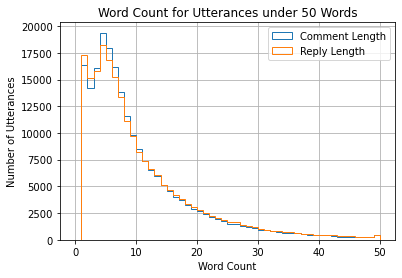

In [69]:
# Graphical summary of our data using a histrogram
df["Comment Length"].hist(histtype='step', bins=50, label='Comment Length')
df["Reply Length"].hist(histtype='step', bins=50, label='Reply Length')
plt.title('Word Count for Utterances under 50 Words')
plt.xlabel('Word Count')
plt.ylabel('Number of Utterances')
plt.legend()
plt.show()

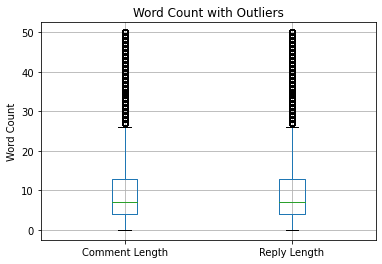

In [70]:
# Graphical summary of our data using a boxplot
df.boxplot(column=['Comment Length','Reply Length'])
plt.title('Word Count with Outliers')
plt.ylabel('Word Count')
plt.show()

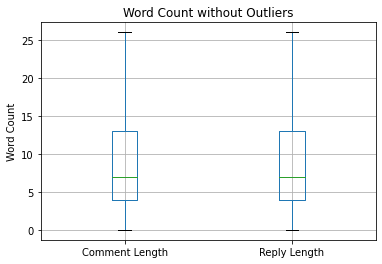

In [71]:
# Graphical summary of our data using a boxplot without outliers
df.boxplot(column=['Comment Length','Reply Length'], showfliers=False)
plt.title('Word Count without Outliers')
plt.ylabel('Word Count')
plt.show()

The dataset is ready to be exported for now. Any additional cleaning could be done once we start exploring the data during Exploratory Data Analysis (EDA).

In [72]:
# Generating path to processed_files directory
processed_files_dir = main_chatbot_dir + '/processed_files'

In [73]:
# Exporting our data as a csv file
df.to_pickle(processed_files_dir + '/processed_movie_dialogues.pkl', compression='xz')